In [8]:
import numpy as np

import os

# for showing the image
import matplotlib.pyplot as plt

# for testing like opening an image
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [40]:
os.listdir('./train/')

['.DS_Store', 'healthy', 'cordana', 'pestalotiopsis', 'sigatoka']

In [22]:
# training dataset path
training_dataset_path = './train/'

# path to each dataset
healthy_banana_dataset_path = './train/healthy/'
cordona_banana_dataset_path = './train/cordana/'
pestalotiopsis_banana_dataset_path = './train/pestalotiopsis/'
sigatoka_banana_dataset_path = './train/sigatoka/'

# Find mean and std

In [49]:
train_dataset = torchvision.datasets.ImageFolder(root=training_dataset_path, transform=transforms.Compose([transforms.ToTensor()]))

In [50]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=False)

In [51]:
def get_mean_and_std(loader):
    mean = 0
    std = 0
    total_images = 0

    for images, _ in loader:
        images_per_batch = images.size(0)
        # print(images.shape) 
        images = images.view(images_per_batch, images.size(1), -1) # reshape image
        # print(images.shape)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += images_per_batch

    mean /= total_images 
    std /= total_images

    # approx mean and std not actual precise mean and std
    return mean, std

In [52]:
mean, std = get_mean_and_std(train_loader)
print(mean, std) # tensor([0.5285, 0.5606, 0.3673]) tensor([0.1232, 0.1068, 0.1230])

tensor([0.5285, 0.5606, 0.3673]) tensor([0.1232, 0.1068, 0.1230])


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/PIL/JpegImagePlugin.py:890: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(


# Data Preparation

In [54]:
# Data Transformation
# no need to resize! already resized to 224 x 224 px
train_transform = transforms.Compose([
    # convert images to pytorch tensors
    transforms.ToTensor(), 
    
    # transforms.Normalize(mean=[mean_R, mean_G, mean_B], std=[std_R, std_G, std_B])
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std)) 
])

In [55]:
train_dataset = torchvision.datasets.ImageFolder(root=training_dataset_path, transform=train_transform)

In [73]:
def show_transformed_dataset(dataset):
    # batch_size = number of images
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=25, shuffle=True) 
    batch = next(iter(loader))
    images, label = batch

    grid = torchvision.utils.make_grid(images, nrow=5)
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(grid, (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.249683..5.1449695].


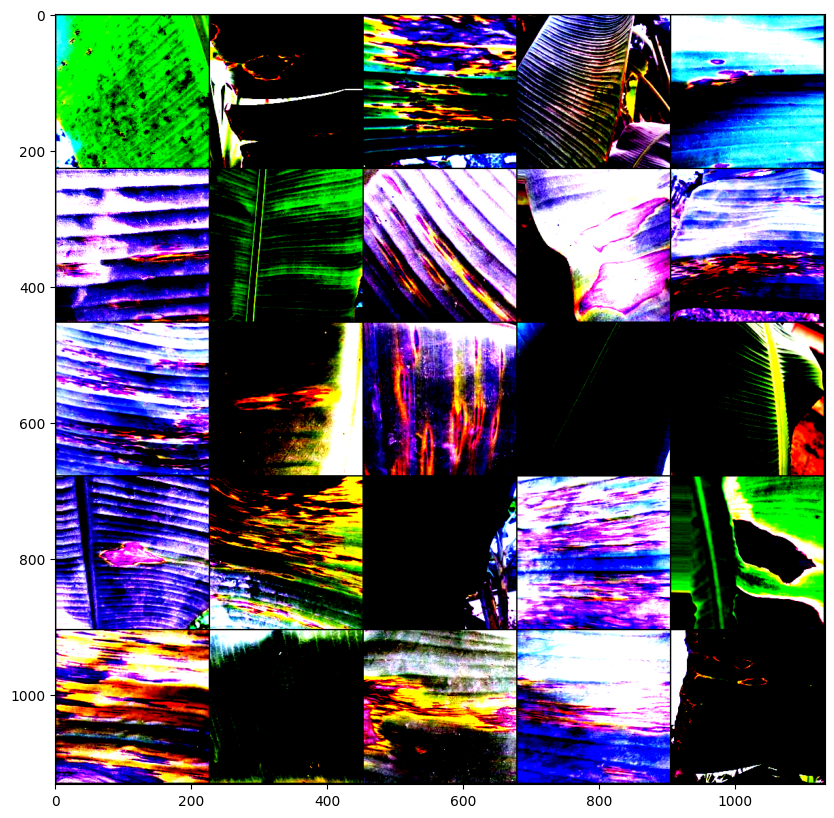

In [74]:
show_transformed_dataset(train_dataset)